# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [5]:
!pip install adabelief_pytorch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [6]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

#새롭게 추가한 거
from torch.utils.data import random_split
from adabelief_pytorch import AdaBelief

In [7]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [8]:
#batch size, augmentation 기법 추가

#test data 수정 x
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

#training data만 수정
transforms_cifar10_training = transforms.Compose([transforms.Resize((32, 32)), #수정 x
                                  transforms.RandomCrop(32, padding=4),  #augmentation 기법 4줄 추가 randomcrop -> 이미지의 다양한 부분 학습 가능
                                  transforms.RandomHorizontalFlip(),
                                  # transforms.RandomRotation(15),
                                  # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                  transforms.ToTensor(), #수정 x
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #수정 ㄱㅊ
                                 ])


# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10_training)

#Train-Validation split
train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size
train_subset, valid_subset = random_split(trainset, [train_size, valid_size])

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2) #batch size 수정하기 4 -> 64 : 배치크기 늘ㄹ리면 학습 속도 빨라지고 일반화 성능 향상됨.
validloader = torch.utils.data.DataLoader(valid_subset, batch_size=64, shuffle=False, num_workers=2) #batch size 수정하기 4 -> 64 : 배치크기 늘ㄹ리면 학습 속도 빨라지고 일반화 성능 향상됨.

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2) #train batch size랑 맞추기

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:04<00:00, 41639857.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


horse  deer  deer   dog


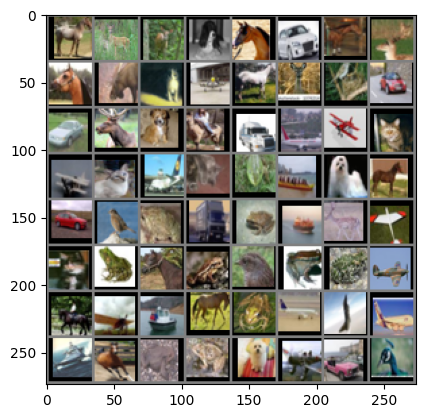

In [9]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [10]:
# Model

class SimpleNet(nn.Module):
    # def __init__(self):
    #     super(SimpleNet, self).__init__()
    #     self.conv1 = nn.Conv2d(3, 6, 5) #(input channel, output channel, kernel_size, stride, padding)
    #     self.pool = nn.MaxPool2d(2, 2)
    #     self.conv2 = nn.Conv2d(6, 16, 5)
    #     self.fc1 = nn.Linear(16 * 5 * 5, 120)
    #     self.fc2 = nn.Linear(120, 84)
    #     self.fc3 = nn.Linear(84, 10)


    # 채널 수 증가 6->32, 16->64, 128 추가
    # conv 커널 크기 5 -> 3
    # 패딩 추가해서 입력 이미지 크기 유지하도록
    # 완전 연결 레이어 크기 증가 120 -> 512, 84 -> 256
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # (input channel, output channel, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 10)

        self.residual1 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128)
        )

        self.residual2 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256)
        )

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        res1 = self.residual1(x) + x
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        res2 = self.residual2(x) + x
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.global_avg_pool(x)
        x = x.view(-1, 1024)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    # def forward(self, x):
    #     x = self.pool(F.relu(self.conv1(x)))
    #     x = self.pool(F.relu(self.conv2(x)))
    #     x = x.view(-1, 16 * 5 * 5) ####### <------------ batch size * ? -> flattened (fc에 넣으려고)
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = self.fc3(x)
    #     return x


net = SimpleNet().to(device)

In [11]:
# # VGG Model

# cfg = {'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']}

# class VGG11(nn.Module):
#     def __init__(self):
#         super(VGG11, self).__init__()
#         self.features = self.make_layers(cfg['VGG11'])
#         self.classifier = nn.Linear(512, 10)

#     def make_layers(self, cfg):
#         layers = []
#         in_channels = 3
#         for x in cfg:
#             if x == 'M':
#                 layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#             else:
#                 layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
#                            nn.BatchNorm2d(x),
#                            nn.ReLU(inplace=True)]
#                 in_channels = x
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
#         return nn.Sequential(*layers)


#     def forward(self, x):
#         out = self.features(x)
#         out = out.view(out.size(0), -1)
#         out = self.classifier(out)
#         return out


# net = VGG11().to(device)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [12]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [14]:
# Loss function and optimizer

# criterion = nn.CrossEntropyLoss() #얘는 정답만 1, 나머지는 0 -> 모델이 극단적, 과신
criterion = LabelSmoothingLoss(classes=10, smoothing=0.05) #정답은 1보다 작은 값, 나머지는 0이 아닌 작은 값 / 실험으로 적절한 smoothing 값 찾기

optimizer = AdaBelief(net.parameters(), lr=1e-3, eps=1e-16, betas=(0.9, 0.999))
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4) #weight decay 추가

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


# **Train the network**

Train your own network using the above loss function and optimizer.

In [15]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def __call__(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif self.best_loss - validation_loss > self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            return True
        return False

In [16]:
early_stopping = EarlyStopping(patience=10, min_delta=0.01)

# Train the model
epochs = 100  # number of epochs

for epoch in range(epochs):
    net.train()
    loss_tmp = 0.0
    epoch_loss = 0.0

    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = net(inputs)

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels)

        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0


    # # Update the learning rate according to the learnig rate scheduler
    # scheduler.step()

    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1)))

    net.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.data
    validation_loss /= len(validloader)
    print('[Epoch - %d] Validation Loss: %.3f' % (epoch + 1, validation_loss))

    #Plateau sheduler를 위한 step 추가
    scheduler.step(validation_loss)

    if early_stopping(validation_loss):
        print('Early stopping at epoch %d' % (epoch + 1))
        break

print('Finished Training')

[Epoch - 1] Loss: 1.566
[Epoch - 1] Validation Loss: 1.300
[Epoch - 2] Loss: 1.245
[Epoch - 2] Validation Loss: 1.269
[Epoch - 3] Loss: 1.129
[Epoch - 3] Validation Loss: 1.154
[Epoch - 4] Loss: 1.053
[Epoch - 4] Validation Loss: 1.032
[Epoch - 5] Loss: 0.995
[Epoch - 5] Validation Loss: 1.028
[Epoch - 6] Loss: 0.935
[Epoch - 6] Validation Loss: 0.928
[Epoch - 7] Loss: 0.885
[Epoch - 7] Validation Loss: 1.128
[Epoch - 8] Loss: 0.843
[Epoch - 8] Validation Loss: 0.906
[Epoch - 9] Loss: 0.809
[Epoch - 9] Validation Loss: 0.829
[Epoch - 10] Loss: 0.772
[Epoch - 10] Validation Loss: 0.836
[Epoch - 11] Loss: 0.740
[Epoch - 11] Validation Loss: 0.750
[Epoch - 12] Loss: 0.710
[Epoch - 12] Validation Loss: 0.809
[Epoch - 13] Loss: 0.681
[Epoch - 13] Validation Loss: 0.743
[Epoch - 14] Loss: 0.658
[Epoch - 14] Validation Loss: 0.733
[Epoch - 15] Loss: 0.636
[Epoch - 15] Validation Loss: 0.704
[Epoch - 16] Loss: 0.609
[Epoch - 16] Validation Loss: 0.692
[Epoch - 17] Loss: 0.592
[Epoch - 17] Vali

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


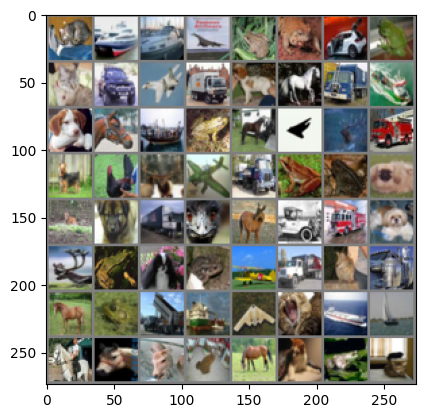

In [17]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [18]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

Accuracy of the network on the 10,000 test images: 91 %
